<a href="https://colab.research.google.com/github/pranjalchaubey/Predicting-Stock-Direction/blob/master/src/Stock_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Direction
In this notebook we are going to use Random Forests to predict the direction  
of stocks for the next trading day.  
In more technical terms, we are going to try and predict the _**Momentum**_  
of the stocks.  
Based on the momentum, we are going to give the following signals to the user  
1. Buy (_+ve momentum_)
2. Sell (_-ve momentum_)
3. Hold (_neutral_)  

This system will work on the daily closing prices and will generate the signals by predicting the momentum for the next trading day. 

##Setup The Colab Environment 
Install and Import the required libraries.  

In [0]:
# Debug Flag
_GLOBAL_DEBUG_ = True

In [2]:
# Install the yFinance library 
!pip install -q yfinance 

In [0]:
# yFinance will help us fetch the data for our dataset
import yfinance as yf

In [0]:
# Data Mining and plotting 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Classifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import os
import sys
import shutil
# if in Google Colaboratory
try:
    from google.colab import drive
except:
    pass

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Configure Pandas Display Options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [8]:
# Since I am running this notebook on Colab, 
# Let's try and get some system information 
import platform
print('System Processor: ', platform.processor(), '\n')
!nvidia-smi

System Processor:  x86_64 

Tue Oct  1 19:49:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

## Load the Data
We will extract the 5 year history of 10 stocks chosen by the user. 

<br/>Here, we will take the following stocks as an example
1. Facebook FB
2. Apple AAPL
3. Amazon AMZN
4. Netflix NFLX
5. Google GOOGL
6. Starbucks SBUX
7. Exxon Mobil XOM
8. Johnson & Johnson JNJ
9. Bank of America BAC
10. General Motors GM

<br/>In the actual application, stock selection will be done by the user. 

In [0]:
# List of stock tickers 
# this info will come from the user, perhaps in the form of a pickle file 
ticker_list = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'SBUX', 'XOM', 'JNJ',\
               'BAC', 'GM']

In [0]:
def fetch_ticker_data(tickers): 
    """
    Fetch 5 years of historical data for the 'tickers', from Yahoo Finance.    

    Parameters
    ----------
    tickers : List   
        List of stocks chosen by the user.   
        
    Returns
    -------
    data : Dataframe 
        Pandas df with historical stock data time series. 
    """
    # Debug 
    _LOCAL_DEBUG_ = False

    # Get the Data from Yahoo! Finance
    data = yf.download(tickers, start="2009-01-01", end="2019-09-07")
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(data.head(20))

    # Data is multi-indexed on the columns 
    # Make it multi-index on the rows, to make it 
    # fit for consumption by the RandomForestClassiffier
    data = data.stack(1) 
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(data.head(20))

    # Drop all the columns except for Adj Close & Volume
    data = data[['Adj Close', 'Volume']]
    # Rename the column names 
    data.columns = ['close', 'volume']  
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        display(data.head(20))

    return data

In [11]:
# Go fetch! 
dataset = fetch_ticker_data(tickers=ticker_list)

[*********************100%***********************]  10 of 10 downloaded


## Data Preprocessing
Now that we have the data downloaded and neatly organized in a dataframe,  
time to do some necessary preprocessing.  
In particular, we are going to use the _log returns_ of the stocks to create a  
target column, called `target`.  
The target variable will be created using the following criteria  
```
  -1 = Sell = ret < -0.0015
   0 = Hold = -0.0015 < ret < 0.0015 
   1 = Buy  = ret > .0015
```

In [0]:
def classify_return(ret):
    """
    Classify the returns as -1, 0 or 1.
    -1 = Sell = ret < -0.0015
    0 = Hold = -0.0015 < ret < 0.0015 
    1 = Buy  = ret > .0015

    Parameters
    ----------
    ret : Float   
        Stock return for the current day, d. 
        retd = log(retd) - log(ret(d-1))

    Returns
    -------
    ret_category : Integer
        Category of return, ret. 
        -1, 0 or 1. 
    """
    ret_category = 0
    
    if ret < -0.0015: 
        ret_category = -1
    elif -0.0015 < ret and ret < 0.0015:
        ret_category = 0
    elif ret > 0.0015:
        ret_category = 1

    return ret_category

In [0]:
def data_preprocess(dataset):
    """
    Calculates log returns and creates the 'target' column.

    Parameters
    ----------
    dataset : Pandas Dataframe
    Dataframe containing price, volume and other 
    information of the chosen stocks. 

    Returns
    -------
    Processed dataframe with two additional columns,
    'returns' and 'target'. 
    returns = log returns of prices 
    target = target column for the classifier to predict
    """
    # Debug Flag
    _LOCAL_DEBUG_ = False 

    # Advance the prices by 1 day to calculate the log returns 
    dataset['shift'] = dataset.groupby(level=1)['close'].shift(1)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        dataset.head(30)

    # Create the 'returns' column
    dataset['returns'] = np.log(dataset['close']) - np.log(dataset['shift'])
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        dataset.head(30)   

    # Drop the first row as it contains NANs in the returns column
    dataset.drop(index = dataset.index.levels[0].values[0], level=0,\
                 inplace=True)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        dataset.head(30)

    # Create the 'target' column for the classifier 
    # Shift the 'target' into the future by 1 day as well by 'shift(-1)'
    # We do this since we are predicting returns of the 'next day close'
    dataset['target'] = dataset['returns'].apply(lambda x: classify_return(x))
    dataset['target'] = dataset.groupby(level=1)['target'].shift(-1)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        dataset.head(30)

    # Drop the 'shift' column as it was only temporary to calculate 'returns'
    dataset.drop(['shift'], axis=1, inplace=True)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        dataset.head(30)

    # Handle NANs
    # We keep it simple at the moment and simply drop off rows with NANs 
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print(dataset.shape)
        print(dataset.isna().sum())
    dataset.dropna(how='any', inplace=True)
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print(dataset.shape)
        print(dataset.isna().sum())

    return dataset

Pre-process the downloaded dataset. 

In [14]:
display(dataset.head(20))
dataset = data_preprocess(dataset)
display(dataset.head(20))
display(dataset.tail())

close       volume
Date                                 
2009-01-02 AAPL    11.31  186503800.0
           AMZN    54.36    7296400.0
           BAC     12.89   86580700.0
           GOOGL  160.82    7213700.0
           JNJ     43.72   11638900.0
           NFLX     4.27    6605200.0
           SBUX     4.22   14885400.0
           XOM     58.45   35803700.0
2009-01-05 AAPL    11.79  295402100.0
           AMZN    54.06    9509800.0
           BAC     12.57   93640500.0
           GOOGL  164.19    9768200.0
           JNJ     43.28   15540000.0
           NFLX     4.56   13044500.0
           SBUX     4.25   16070600.0
           XOM     58.44   43340100.0
2009-01-06 AAPL    11.60  322327600.0
           AMZN    57.36   11080100.0
           BAC     12.84  111015400.0
           GOOGL  167.20   12837500.0

close       volume   returns  target
Date                                                   
2009-01-05 AAPL    11.79  295402100.0  0.041564    -1.0
           AMZN    54.06    9509800.0 -0.005534     1.0
           BAC     12.57   93640500.0 -0.025139     1.0
           GOOGL  164.19    9768200.0  0.020739     1.0
           JNJ     43.28   15540000.0 -0.010115    -1.0
           NFLX     4.56   13044500.0  0.065709     1.0
           SBUX     4.25   16070600.0  0.007084     1.0
           XOM     58.44   43340100.0 -0.000171    -1.0
2009-01-06 AAPL    11.60  322327600.0 -0.016247    -1.0
           AMZN    57.36   11080100.0  0.059253    -1.0
           BAC     12.84  111015400.0  0.021252    -1.0
           GOOGL  167.20   12837500.0  0.018166    -1.0
           JNJ     43.02   22097600.0 -0.006026    -1.0
           NFLX     4.71   12065900.0  0.032365    -1.0
           SBUX     4.38   17609800.0  0.030130    -1.0
           XOM     57.49   41906100.0 -0.016390    -1.0
2009-01-07 AAPL    11.35  188262200.0 -0.021787     1.0
           AMZN    56.20    7942700.0 -0.020430     1.0
           BAC     12.33  112810000.0 -0.040530    -1.0
           GOOGL  161.17    8980000.0 -0.036731     1.0

close     volume   returns  target
Date                                                  
2019-09-05 GOOGL  1212.19  1319700.0  0.024992    -1.0
           JNJ     128.58  4754100.0 -0.002175    -1.0
           NFLX    293.25  8966800.0  0.005917    -1.0
           SBUX     95.56  5514400.0 -0.005739     1.0
           XOM      70.27  9901500.0  0.014044     1.0

## Feature Engineering 
Leaving this section blank at the moment. Will come back at a later time. 

## Train Test Split 
Split the data into testing and training sets.  
In production, there's going to be only re-training of the model that we have  
chosen with the specified hyper-parameters. 

In [0]:
def train_test_split(dataset, features, target, train_size, test_size):
    """
    Generate the train and test dataset.

    Parameters
    ----------
    dataset : DataFrame
        All the samples including target
    features : List
        List of the names of columns that are features
    target : String
        Name of column that is the target (in our case, 'target')
    train_size : float
        The proportion of the data used for the training dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_test : Pandas Series
        The test target values
    """
    # Data Sanity check 
    assert train_size >= 0 and train_size <= 1.0, 'Train size out of bounds!'
    assert test_size >= 0 and test_size <= 1.0, 'Test size out of bounds!'
    assert train_size + test_size == 1.0, 'Train + Test should be equal to 1!'
    
    # Debug Flag 
    _LOCAL_DEBUG_ = False
    
    # Extract the x and y from the dataset
    all_x = dataset[features]
    all_y = dataset[target]
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print(all_x.head())
        print(all_y.head())
        print('dataset.shape ', dataset.shape)

    # Get the number of rows in df and no of elements in the pandas series 
    # NOTE - Both are multi-indexed
    len_x = len(all_x.index.levels[0])
    len_y = len(all_y.index.levels[0])
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print('Len x ', len_x)
        print('Len y ', len_y)
    
    # Some fancy calculations here for x
    x_train = all_x.loc[all_x.index.levels[0]\
                        [:int(len_x*train_size)].astype(str).tolist()]
    x_test = all_x.loc[all_x.index.levels[0]\
                       [int(len_x*train_size):int(len_x*train_size) + int(len_x*test_size)]\
                       .astype(str).tolist()]
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print('x_train.shape ', x_train.shape)
        print('x_test.shape ', x_test.shape)

    # Some fancy calculations here for y as well
    y_train = all_y.loc[all_y.index.levels[0]\
                        [:int(len_y*train_size)].astype(str).tolist()]
    y_test = all_y.loc[all_y.index.levels[0]\
                       [int(len_y*train_size):int(len_y*train_size) + int(len_y*test_size)]\
                       .astype(str).tolist()]
    if _GLOBAL_DEBUG_ and _LOCAL_DEBUG_:
        print('y_train.shape ', y_train.shape)
        print('y_test.shape ', y_test.shape)
 
    return x_train, x_test, y_train, y_test 

In [0]:
# In our dataset all the columns except for the 'target' column are features
# Temporarily drop the 'target' and extract the features  
features = dataset.drop(['target'], axis=1).columns.values.tolist()

# Get the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(dataset=dataset,\
                                                    features=features,\
                                                    target='target',\
                                                    train_size=0.9,\
                                                    test_size=0.1)

In [17]:
# Validate the results 
print('dataset.shape ', dataset.shape)
print('X_train.shape ', X_train.shape)
print('X_test.shape ', X_test.shape)
print('y_train.shape ', y_train.shape)
print('y_test.shape ', y_test.shape)

dataset.shape  (25535, 4)
X_train.shape  (22855, 3)
X_test.shape  (2680, 3)
y_train.shape  (22855,)
y_test.shape  (2680,)


## Hyperparameter Search
We have the dataset in our hand with train and test splits.  
Time to train our _Random Forest Classifier_, and look for the best set of  
hyperparameters.  

1. Create a plotting function to help in evaluating the performance of RFCs  
2. Display the ranked feature importances 
3. Declare a hyperparameter _'grid'_ for the various RFCs to train on
4. Train the RFCs 
5. Based on performance, choose the best set of hyperparameters. 

In [0]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    """
    Generate a plot of xs vs ys.

    Parameters
    ----------
    xs : List
        List of x-axis values  
    ys : List
        List of y-axis values  
    labels : List
        List of strings containing the name of legends
    title : String
        Plot Title
    x_label : String
        Name of the x-axis
    y_label : String
        Name of the y-axis

    Returns
    -------
    None. Just plots the plot.
    """
    plt.rcParams['figure.figsize'] = [12, 6]
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.4, 0.7))
        plt.plot(x, y, label=label)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

    return None

In [0]:
def rank_features_by_importance(importances, feature_names):
    """
    Ranks and Pretty prints the feature importances as 
    evaluated by the Random Forest Classifier. 

    Parameters
    ----------
    importances : ndarray
        A numpy array containing feature importance values  
    feature_names : List
        A list of strings containing the names of features

    Returns
    -------
    None. Just ranks and pretty prints the features along 
    with their importance. 
    """
    indices = np.argsort(importances)[::-1]
    max_feature_name_length = max([len(feature) for feature in feature_names])

    for x_train_i in range(len(importances)):
        print('{number:>2}. {feature: <{padding}} ({importance})'.format(
            number=x_train_i + 1,
            padding=max_feature_name_length,
            feature=feature_names[indices[x_train_i]],
            importance=importances[indices[x_train_i]]))

    return None

In [0]:
# Hyperparameters 
# This is to get consistent results between each run.
clf_random_state = 0

n_days = 5
n_stocks = len(ticker_list)

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [5, 10, 25, 50, 75, 100]

In [29]:
%%timeit -n 1 -r 1
# Train the Classifier 
train_score = []
test_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    test_score.append(clf.score(X_test, y_test.values))
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 6/6 [00:12<00:00,  2.65s/Model]

1 loop, best of 1: 12.7 s per loop


Features Ranked by Average Importance:

 1. close   (0.34364709008816563)
 2. returns (0.33504430292733617)
 3. volume  (0.3213086069844982)


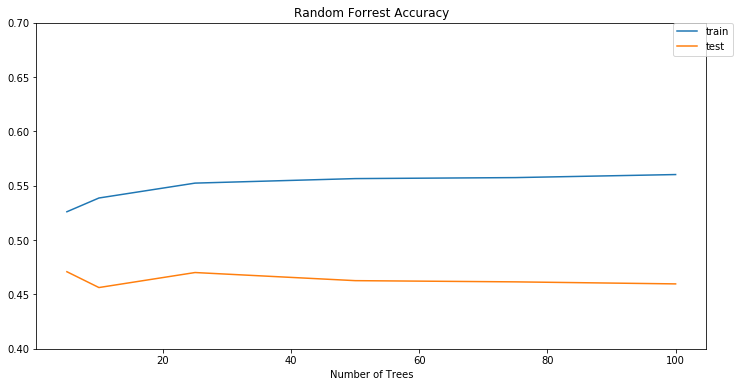

In [37]:
# The most important features 
print('Features Ranked by Average Importance:\n')
rank_features_by_importance(np.average(feature_importances, axis=0), features)

# Visualize the performance of the various classifiers 
plot([n_trees_l]*3,
    [train_score, test_score],
    ['train', 'test'],
    'Random Forrest Accuracy',
    'Number of Trees')